Before starting, you will need to install some packages to reproduce the baseline.

In [19]:
!pip install tqdm
!pip install scikit-learn

^C
ERROR: Operation cancelled by user


In [2]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Data architecture

After downloading or unzipping the downloaded files, your data tree must have the following architecture in order to properly run the notebook:
```
your_data_dir/
├── train_output.csv
├── train_input/
│   ├── images/
│       ├── ID_001/
│           ├── ID_001_tile_000_17_170_43.jpg
...
│   └── moco_features/
│       ├── ID_001.npy
...
├── test_input/
│   ├── images/
│       ├── ID_003/
│           ├── ID_003_tile_000_16_114_93.jpg
...
│   └── moco_features/
│       ├── ID_003.npy
...
├── supplementary_data/
│   ├── baseline.ipynb
│   ├── test_metadata.csv
│   └── train_metadata.csv
```

For instance, `your_data_dir = /storage/DATA_CHALLENGE_ENS_2022/`


This notebook aims to reproduce the baseline method on this challenge called `MeanPool`. This method consists in a logistic regression learnt on top of tile-level MoCo V2 features averaged over the slides.

For a given slide $s$ with $N_s=1000$ tiles and corresponding MoCo V2 features $\mathbf{K_s} \in \mathbb{R}^{(1000,\,2048)}$, a slide-level average is performed over the tile axis.

For $j=1,...,2048$:

$$\overline{\mathbf{k_s}}(j) = \frac{1}{N_s} \sum_{i=1}^{N_s} \mathbf{K_s}(i, j) $$

Thus, the training input data for MeanPool consists of $S_{\text{train}}=344$ mean feature vectors $\mathbf{k_s}$, $s=1,...,S_{\text{train}}$, where $S_{\text{train}}$ denotes the number of training samples.

## Data loading

In [3]:
# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path("/Users/clementdesroches/Documents/MINES_3A/owkin_data_challenge")

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train = pd.read_csv(data_dir  / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir  / "supplementary_data" / "test_metadata.csv")

# concatenate y_train and df_train
y_train = pd.read_csv(data_dir  / "train_output.csv")
df_train = df_train.merge(y_train, on="Sample ID")

print(f"Training data dimensions: {df_train.shape}")  # (344, 4)
df_train.head()

Training data dimensions: (344, 4)


,Sample ID,Patient ID,Center ID,Target
0,ID_001.npy,P_001,C_1,0
1,ID_002.npy,P_002,C_2,1
2,ID_005.npy,P_005,C_5,0
3,ID_006.npy,P_006,C_5,0
4,ID_007.npy,P_007,C_2,1


## Data processing

We now load the features matrices $\mathbf{K_s} \in \mathbb{R}^{(1000,\,2048)}$ for $s=1,...,344$ and perform slide-level averaging. This operation should take at most 5 minutes on your laptop.

In [4]:
X_train = []
y_train = []
centers_train = []
patients_train = []

for sample, label, center, patient in tqdm(
    df_train[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
    # slide-level averaging
    X_train.append(features)
    y_train.append(label)
    centers_train.append(center)
    patients_train.append(patient)

# convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
centers_train = np.array(centers_train)
patients_train = np.array(patients_train)

100%|██████████| 344/344 [00:03<00:00, 94.69it/s] 


In [5]:
print(f"X_train shape: {X_train.shape}")  # (344, 1000, 2048)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[2],  X_train.shape[1])
# print(f"X_train shape: {X_train.shape}")  # (344, 2048, 1000)


X_train shape: (344, 1000, 2048)


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class SoftMaxMeanSimple(torch.nn.Module):
    def __init__(self, n = 2048, n_inst = 1000, dim=1):
        """
        if dim==1:
            given a tensor `x` with dimensions [N * M],
            where M -- dimensionality of the featur vector
                       (number of features per instance)
                  N -- number of instances
            initialize with `AggModule(M)`
            returns:
            - weighted result: [M]
            - gate: [N]
        if dim==0:
            ...
        """
        super(SoftMaxMeanSimple, self).__init__()
        self.dim = dim
        self.gate = torch.nn.Softmax(dim=self.dim)      
        self.mdl_instance_transform = nn.Sequential(
                            nn.Linear(n, 10),
                            nn.LeakyReLU(),
                            nn.Linear(10, n),
                            nn.LeakyReLU(),
                            )
    def forward(self, x):
        z = self.mdl_instance_transform(x)
        z = torch.sum(z, 2)
        gate_ = self.gate(z)
        ## reshaping gate duplicating last dim 2048 times
        gate_ = gate_.unsqueeze(2).repeat(1, 1, 2048)
        # shape = x.shape
        # x2 = x.reshape(shape[0], shape[2], shape[1])
        ## ponderated sum
        res = x * gate_
        res = torch.sum(res, 1)
        return res, gate_

class LogisticRegression(torch.nn.Module):
    def __init__(self, n=2048, n_out=1):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n, n_out)
        self.drop = torch.nn.Dropout(0.25)
        self.scoring = torch.nn.Softmax() if n_out>1 else torch.nn.Sigmoid()

    def forward(self, x):
        z = self.linear(x)
        z = self.drop(z)
        y_pred = self.scoring(z)
        return y_pred

    
def regularization_loss(params,
                        reg_factor = 0.005,
                        reg_alpha = 0.5):
    params = [pp for pp in params if len(pp.shape)>1]
    l1_reg = nn.L1Loss()
    l2_reg = nn.MSELoss()
    loss_reg =0
    for pp in params:
        loss_reg+=reg_factor*((1-reg_alpha)*l1_reg(pp, target=torch.zeros_like(pp)) +\
                           reg_alpha*l2_reg(pp, target=torch.zeros_like(pp)))
    return loss_reg


class MIL_NN(torch.nn.Module):

    def __init__(self, n=2048,  
                 n_classes=1, 
                 dropout=0.1,
                 agg = None,
                 scoring=None,
                ):
        super(MIL_NN, self).__init__()
        self.agg = agg if agg is not None else SoftMaxMeanSimple(n)
        self.bag_model = LogisticRegression(n, n_classes)

        
    def forward(self, bag_features, bag_lbls=None):
        """
        bag_feature is an aggregated vector of 512 features
        bag_att is a gate vector of n_inst instances
        bag_lbl is a vector a labels
        figure out batches
        """
        bag_agg, bag_att = self.agg(bag_features)
        y_pred = self.bag_model(bag_agg)
        return y_pred

In [22]:
## train val split
from sklearn.model_selection import train_test_split
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train_2 = torch.from_numpy(X_train1).float()
y_train_2 = torch.from_numpy(y_train1).float()

X_val_2 = torch.from_numpy(X_val1).float()
y_val_2 = torch.from_numpy(y_val1).float()

model = MIL_NN()



def train_model(epoch):
    # clearing the Gradients of the model parameters
    optimizer.zero_grad()

    # prediction for training and validation set
    output_train = model(X_train_2)
    output_val = model(X_val_2)

    ## shape is (34, 1) -> (34)
    output_train = output_train.squeeze()
    output_val = output_val.squeeze()

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train_2)
    train_losses.append(loss_train.detach().numpy())
    train_acc.append(roc_auc_score(y_train_2, output_train.detach().numpy()))
    loss_val = criterion(output_val, y_val_2)
    val_losses.append(loss_val.detach().numpy())
    val_acc.append(roc_auc_score(y_val_2, output_val.detach().numpy()))

    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%1 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_train, '\t', 'acc :', train_acc[-1], '\t', 'val_loss :', loss_val, '\t', 'val_acc :', val_acc[-1])

In [24]:
X_train_2.shape, X_val_2.shape, y_train_2.shape, y_val_2.shape

(torch.Size([275, 1000, 2048]),
 torch.Size([69, 1000, 2048]),
 torch.Size([275]),
 torch.Size([69]))

In [25]:
# X_train_2 = X_train_2.reshape(34, 2048, 1000)
# X_val_2 = X_val_2.reshape(310, 2048, 1000)

In [27]:
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## degressive learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


# model:

# params you need to specify:
n_epochs = 10
lr0 = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=lr0)
criterion = torch.nn.BCELoss()

train_losses = []
# accuracy on training set
train_acc = []
# empty list to store validation losses
val_losses = []

val_acc = []

if torch.cuda.is_available():
    net = model.cuda()
    criterion = criterion.cuda()
# training the model
for epoch in range(n_epochs):
    #learning rate decay
    lr = get_lr(optimizer)
    print('lr :', lr)
    train_model(epoch)
    

lr : 0.1
torch.Size([275, 1000, 2048])
torch.Size([275, 1000, 2048])
torch.Size([69, 1000, 2048])
torch.Size([69, 1000, 2048])
Epoch :  1 	 loss : tensor(0.6891, grad_fn=<BinaryCrossEntropyBackward0>) 	 acc : 0.48459056519804183 	 val_loss : tensor(0.6867, grad_fn=<BinaryCrossEntropyBackward0>) 	 val_acc : 0.41865079365079366
lr : 0.1
torch.Size([275, 1000, 2048])
torch.Size([275, 1000, 2048])
torch.Size([69, 1000, 2048])
torch.Size([69, 1000, 2048])
Epoch :  2 	 loss : tensor(3.5938, grad_fn=<BinaryCrossEntropyBackward0>) 	 acc : 0.5598019581664442 	 val_loss : tensor(2.6855, grad_fn=<BinaryCrossEntropyBackward0>) 	 val_acc : 0.47718253968253976
lr : 0.1
torch.Size([275, 1000, 2048])
torch.Size([275, 1000, 2048])
torch.Size([69, 1000, 2048])
torch.Size([69, 1000, 2048])
Epoch :  3 	 loss : tensor(1.0783, grad_fn=<BinaryCrossEntropyBackward0>) 	 acc : 0.5658655985758789 	 val_loss : tensor(0.9583, grad_fn=<BinaryCrossEntropyBackward0>) 	 val_acc : 0.49107142857142855
lr : 0.1
torch.Siz

In [36]:
train_losses_array = np.array(train_losses)
val_losses_array = np.array(val_losses)

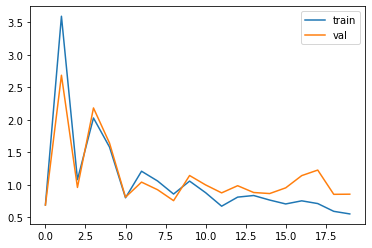

In [37]:
plt.plot(train_losses_array, label='train')
plt.plot(val_losses_array, label='val')
plt.legend()
plt.show()

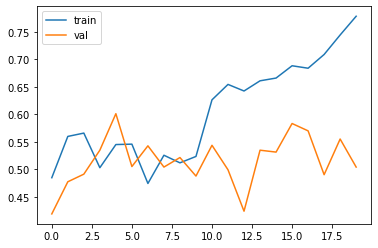

In [38]:
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.legend()
plt.show()

In [35]:
for epoch in range(n_epochs):
    train_model(epoch)

torch.Size([275, 1000, 2048])
torch.Size([275, 1000, 2048])
torch.Size([69, 1000, 2048])
torch.Size([69, 1000, 2048])
Epoch :  1 	 loss : tensor(0.8776, grad_fn=<BinaryCrossEntropyBackward0>) 	 acc : 0.6264463729417 	 val_loss : tensor(0.9974, grad_fn=<BinaryCrossEntropyBackward0>) 	 val_acc : 0.5436507936507937
torch.Size([275, 1000, 2048])
torch.Size([275, 1000, 2048])
torch.Size([69, 1000, 2048])
torch.Size([69, 1000, 2048])
Epoch :  2 	 loss : tensor(0.6697, grad_fn=<BinaryCrossEntropyBackward0>) 	 acc : 0.654539385847797 	 val_loss : tensor(0.8748, grad_fn=<BinaryCrossEntropyBackward0>) 	 val_acc : 0.4990079365079365
torch.Size([275, 1000, 2048])
torch.Size([275, 1000, 2048])
torch.Size([69, 1000, 2048])
torch.Size([69, 1000, 2048])
Epoch :  3 	 loss : tensor(0.8095, grad_fn=<BinaryCrossEntropyBackward0>) 	 acc : 0.6425511793502447 	 val_loss : tensor(0.9850, grad_fn=<BinaryCrossEntropyBackward0>) 	 val_acc : 0.42361111111111116
torch.Size([275, 1000, 2048])
torch.Size([275, 1000,

In [23]:
# save model
torch.save(model.state_dict(), 'model_mil.pt')

# load model
model.load_state_dict(torch.load('model_mil.pt'))

<All keys matched successfully>

In [39]:
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for epoch in range(n_epochs):
    train_model(epoch)

torch.Size([275, 1000, 2048])
torch.Size([275, 1000, 2048])
torch.Size([69, 1000, 2048])
torch.Size([69, 1000, 2048])
Epoch :  1 	 loss : tensor(0.6121, grad_fn=<BinaryCrossEntropyBackward0>) 	 acc : 0.7567311971517579 	 val_loss : tensor(0.8843, grad_fn=<BinaryCrossEntropyBackward0>) 	 val_acc : 0.49950396825396826
torch.Size([275, 1000, 2048])
torch.Size([275, 1000, 2048])
torch.Size([69, 1000, 2048])
torch.Size([69, 1000, 2048])
Epoch :  2 	 loss : tensor(0.6167, grad_fn=<BinaryCrossEntropyBackward0>) 	 acc : 0.7570649755229194 	 val_loss : tensor(0.7537, grad_fn=<BinaryCrossEntropyBackward0>) 	 val_acc : 0.5887896825396826
torch.Size([275, 1000, 2048])
torch.Size([275, 1000, 2048])
torch.Size([69, 1000, 2048])
torch.Size([69, 1000, 2048])
Epoch :  3 	 loss : tensor(0.5908, grad_fn=<BinaryCrossEntropyBackward0>) 	 acc : 0.7553404539385848 	 val_loss : tensor(0.8370, grad_fn=<BinaryCrossEntropyBackward0>) 	 val_acc : 0.5119047619047619
torch.Size([275, 1000, 2048])
torch.Size([275, 1

In [33]:
train_losses

array(0.69259816, dtype=float32)

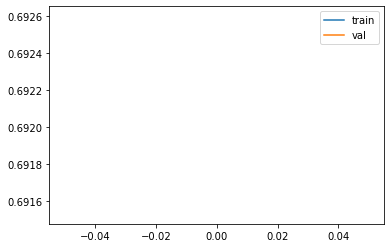

In [32]:
## viz loss
import matplotlib.pyplot as plt
# train_losses = train_losses[0].detach().numpy()
val_losses = val_losses[0].detach().numpy()
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

In [13]:
# predict
X_to_predict = torch.from_numpy(X_train).float()
y_pred = model(X_to_predict)
y_pred = y_pred.squeeze()
y_pred = y_pred.detach().numpy()

# evaluate
roc_auc_score(y_train, y_pred)

0.6669921875

## 5-fold cross validation

In [39]:
# /!\ we perform splits at the patient level so that all samples from the same patient
# are found in the same split

patients_unique = np.unique(patients_train)
y_unique = np.array(
    [np.mean(y_train[patients_train == p]) for p in patients_unique]
)
centers_unique = np.array(
    [centers_train[patients_train == p][0] for p in patients_unique]
)

print(
    "Training set specifications\n"
    "---------------------------\n"
    f"{len(X_train)} unique samples\n"
    f"{len(patients_unique)} unique patients\n"
    f"{len(np.unique(centers_unique))} unique centers"
)

Training set specifications
---------------------------
344 unique samples
305 unique patients
3 unique centers


In [40]:
from xgboost import XGBClassifier

aucs = []
lrs = []
# 5-fold CV is repeated 5 times with different random states
for k in range(5):
    kfold = StratifiedKFold(5, shuffle=True, random_state=k)
    fold = 0
    # split is performed at the patient-level
    for train_idx_, val_idx_ in kfold.split(patients_unique, y_unique):
        # retrieve the indexes of the samples corresponding to the
        # patients in `train_idx_` and `test_idx_`
        train_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[train_idx_])
        ]
        val_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[val_idx_])
        ]
        # set the training and validation folds
        X_fold_train = X_train[train_idx]
        y_fold_train = y_train[train_idx]
        X_fold_val = X_train[val_idx]
        y_fold_val = y_train[val_idx]
        # instantiate the model
        lr = LogisticRegression(C=0.01, solver="liblinear")
        # fit it
        lr.fit(X_fold_train, y_fold_train)
        # get the predictions (1-d probability)
        preds_val = lr.predict_proba(X_fold_val)[:, 1]
        # compute the AUC score using scikit-learn
        auc = roc_auc_score(y_fold_val, preds_val)
        print(f"AUC on split {k} fold {fold}: {auc:.3f}")
        aucs.append(auc)
        # add the logistic regression to the list of classifiers
        lrs.append(lr)
        fold += 1
    print("----------------------------")
print(
    f"5-fold cross-validated AUC averaged over {k+1} repeats: "
    f"{np.mean(aucs):.3f} ({np.std(aucs):.3f})"
)

AUC on split 0 fold 0: 0.572
AUC on split 0 fold 1: 0.511
AUC on split 0 fold 2: 0.512
AUC on split 0 fold 3: 0.633
AUC on split 0 fold 4: 0.370
----------------------------
AUC on split 1 fold 0: 0.445
AUC on split 1 fold 1: 0.660
AUC on split 1 fold 2: 0.431
AUC on split 1 fold 3: 0.488
AUC on split 1 fold 4: 0.522
----------------------------
AUC on split 2 fold 0: 0.515
AUC on split 2 fold 1: 0.460
AUC on split 2 fold 2: 0.533
AUC on split 2 fold 3: 0.623
AUC on split 2 fold 4: 0.470
----------------------------
AUC on split 3 fold 0: 0.587
AUC on split 3 fold 1: 0.438
AUC on split 3 fold 2: 0.519
AUC on split 3 fold 3: 0.481
AUC on split 3 fold 4: 0.474
----------------------------
AUC on split 4 fold 0: 0.505
AUC on split 4 fold 1: 0.475
AUC on split 4 fold 2: 0.509
AUC on split 4 fold 3: 0.436
AUC on split 4 fold 4: 0.593
----------------------------
5-fold cross-validated AUC averaged over 5 repeats: 0.511 (0.068)


# Submission

Now we evaluate the previous models trained through cross-validation so that to produce a submission file that can directly be uploaded on the data challenge platform.

## Data processing

In [19]:
X_test = []

# load the data from `df_test` (~ 1 minute)
for sample in tqdm(df_test["Sample ID"].values):
    _features = np.load(test_features_dir / sample)
    coordinates, features = _features[:, :3], _features[:, 3:]
    X_test.append(features)

X_test = np.array(X_test)
X_test.shape

100%|██████████| 149/149 [00:01<00:00, 130.43it/s]


(149, 1000, 2048)

## Inference

In [20]:
X_test = torch.from_numpy(X_test).float()

In [21]:
preds_test = 0
# predict with mil model
y_pred = model(X_test)
y_pred = y_pred.squeeze()
y_pred = y_pred.detach().numpy()
y_pred

array([0.13798366, 0.2792116 , 0.00773412, 0.03679273, 0.5       ,
       0.22684489, 0.5       , 0.06029327, 0.04766197, 0.5       ,
       0.04330521, 0.21188088, 0.14984669, 0.9217528 , 0.5       ,
       0.2460504 , 0.37499246, 0.5       , 0.51697606, 0.00868678,
       0.0097719 , 0.08249706, 0.20083435, 0.5       , 0.0157528 ,
       0.32231864, 0.6183469 , 0.10087255, 0.5       , 0.5       ,
       0.5       , 0.14838946, 0.48591775, 0.5       , 0.78366107,
       0.5       , 0.5       , 0.5       , 0.26762787, 0.41235155,
       0.01277913, 0.13810149, 0.11030564, 0.44252777, 0.8178266 ,
       0.19061828, 0.12846197, 0.15277494, 0.70782936, 0.03922508,
       0.55833   , 0.5       , 0.04536848, 0.17312051, 0.5       ,
       0.3809631 , 0.12042338, 0.5       , 0.25740492, 0.39667788,
       0.5       , 0.5       , 0.10387964, 0.9880685 , 0.12328187,
       0.5082334 , 0.00534274, 0.7907676 , 0.00795839, 0.14874396,
       0.49336222, 0.5       , 0.6697827 , 0.08958364, 0.5    

## Saving predictions

In [22]:
submission = pd.DataFrame(
    {"Sample ID": df_test["Sample ID"].values, "Target": preds_test}
).sort_values(
    "Sample ID"
)  # extra step to sort the sample IDs

# sanity checks
assert all(submission["Target"].between(0, 1)), "`Target` values must be in [0, 1]"
assert submission.shape == (149, 2), "Your submission file must be of shape (149, 2)"
assert list(submission.columns) == [
    "Sample ID",
    "Target",
], "Your submission file must have columns `Sample ID` and `Target`"

# save the submission as a csv file
submission.to_csv(data_dir / "mil_ae.csv", index=None)
submission.head()

,Sample ID,Target
0,ID_003.npy,0
1,ID_004.npy,0
2,ID_008.npy,0
3,ID_009.npy,0
4,ID_010.npy,0


# Dealing with images

The following code aims to load and manipulate the images provided as part of  this challenge.

## Scanning images paths on disk

This operation can take up to 5 minutes.

In [ ]:
train_images_dir = data_dir / "train_input" / "images"
train_images_files = list(train_images_dir.rglob("*.jpg"))

test_images_dir = data_dir / "test_input" / "images"
test_images_files = list(test_images_dir.rglob("*.jpg"))

print(
    f"Number of images\n"
    "-----------------\n"
    f"Train: {len(train_images_files)}\n" # 344 x 1000 = 344,000 tiles
    f"Test: {len(test_images_files)}\n"  # 149 x 1000 = 149,000 tiles
    f"Total: {len(train_images_files) + len(test_images_files)}\n"  # 493 x 1000 = 493,000 tiles
)

Number of images
-----------------
Train: 0
Test: 0
Total: 0



## Reading

Now we can load some of the `.jpg` images for a given sample, say `ID_001`.

In [ ]:
ID_001_tiles = [p for p in train_images_files if 'ID_001' in p.name]

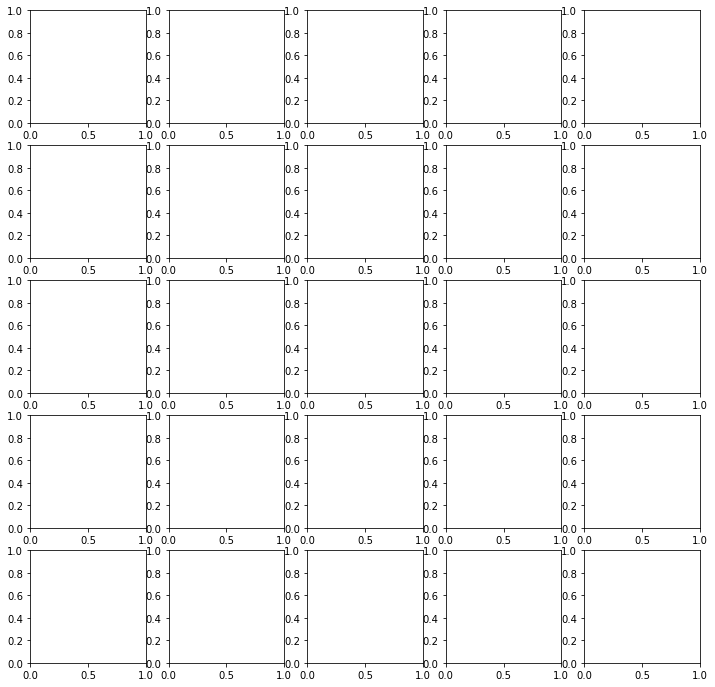

In [ ]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(12, 12)

for i, img_file in enumerate(ID_001_tiles[:25]):
    # get the metadata from the file path
    _, metadata = str(img_file).split("tile_")
    id_tile, level, x, y = metadata[:-4].split("_")
    img = plt.imread(img_file)
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Tile {id_tile} ({x}, {y})")
plt.show()

## Mapping with features

Note that the coordinates in the features matrices and tiles number are aligned.

In [ ]:
sample = "ID_001.npy"
_features = np.load(train_features_dir / sample)
coordinates, features = _features[:, :3], _features[:, 3:]
print("xy features coordinates")
coordinates[:10, 1:].astype(int)

xy features coordinates


array([[170,  43],
       [245,  49],
       [137, 128],
       [218,  40],
       [142, 117],
       [129,  72],
       [129,  88],
       [164, 109],
       [210,  39],
       [222, 100]])

In [ ]:
print(
    "Tiles numbering and features coordinates\n"
)
[tile.name for tile in ID_001_tiles[:10]]

Tiles numbering and features coordinates



[]